In [1]:
import os 
import pandas as pd
import matplotlib.pyplot as plt
from rouge_score import rouge_scorer
import seaborn as sns
import torch
import math
import numpy as np
import sys
import re
import glob
 
usetex = False

ylim = 0.25
axes_size = 12.5
title_size = 13
legend_size = 11

sys.path.append("..")
from utils.data_helpers import calculate_rouge

def aggregate_scores(data_dir, group_by='n_documents', measures=['bleu', 'rouge', 'perplexity'], agg_method=['mean', 'std']):
    # Check if it is a data directory or dataframe
    if isinstance(data_dir, str) and os.path.isdir(data_dir):
        wandb_exp_files = os.listdir(data_dir)
        # get all csv
        print(wandb_exp_files)
        wandb_exp_files = [f for f in wandb_exp_files if f.endswith('.csv')]


        # For the baseline
        # Read all CSV files into a single dataframe
        
        df = pd.concat([pd.read_csv(os.path.join(data_dir, f), encoding='latin-1') for f in wandb_exp_files])

    elif isinstance(data_dir, pd.DataFrame):
        df = data_dir
    # Group by n docs calculate mean and std of each measure
    combined = pd.DataFrame()
    for measure in measures:
        measure_df = df.groupby([group_by])[measure].agg(agg_method)
        measure_df.columns = [f'{measure}_mean', f'{measure}_std']
        combined = pd.concat([combined, measure_df], axis=1)

    return combined, df

# Turning the above into a function
def plot_scores(data, metric='rouge', labels='RAG Model', ylim=0.5, xlabel='number of documents', measure=['mean', 'std']):
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(12, 6))

    # Add label to the line plot
    # Check if it is a list - then plot all the measures
    if isinstance(data, list):
        for d, l in zip(data, labels):
            sns.lineplot(data=d, x=d.index, y=f'{metric}_{measure}', label=l)
    else:
        sns.lineplot(data=data, x=data.index, y=f'{metric}_{measure}', label=labels)

    plt.title(f'{metric} score by {xlabel}')
    plt.ylim(0, ylim)
    plt.xlabel(xlabel)

    # Display the legend
    plt.legend()

    plt.show()


# Check the relationship between cosine distance and rouge
import scipy.stats as stats
def plot_rouge_cosine_similarity(df):
    color="#6B7B8C"

    df = df[~df['predicted'].isna()]
    df['rouge_max'] = df.apply(lambda row: calculate_rouge(row['gold'], row['predicted']),axis=1)
    df['similarities'] = df['similarities'].apply(lambda x: x.split(',') if isinstance(x, str) else x)
    df = df[~df['similarities'].isna()]
    df['similarities'] = df['similarities'].apply(lambda x: [float(i) for i in x] if isinstance(x, list) else x)    
    df['similarities_mean'] = df['similarities'].apply(lambda x: np.mean(x))

    #calculating the pearson correlation between the cosine and rouge
    pearson = df['similarities_mean'].corr(df['rouge_max'])
    print(f'Pearson correlation: {pearson}')
    scip_pearson = stats.pearsonr(df['similarities_mean'], df['rouge_max'])
    print(f'Scipy Pearson correlation: {scip_pearson}')
    plt.rcParams.update({
        "text.usetex": True,
        "font.family": "Computer Modern Roman"
    })
    plt.rcParams['text.usetex'] = True
        
    axes_size = 12.5
    title_size = 13
    legend_size = 11

    # Set the x-ticks
    # Only the non-zero
    df_non_zero = df[df['rouge_max']!= 0]
    # add a smaller radious to the points
    plt.scatter(df_non_zero['similarities_mean'], df_non_zero['rouge_max'], color=color, s=27)
    
    plt.ylabel('ROUGE score', fontsize=axes_size)
    plt.xlabel('Average cosine similarity', fontsize=axes_size)
    # fit a line as well
    m, b = np.polyfit(df_non_zero['similarities_mean'], df_non_zero['rouge_max'], 1)
    plt.plot(df_non_zero['similarities_mean'], m*df_non_zero['similarities_mean'] + b, color='red', alpha=0.4, label='Fitted regression line')
    plt.title(f'Relationship between ROUGE score and Cosine similarity for chunks: {df["top_k"].max()}', fontsize=title_size)
    plt.xlim(df_non_zero['similarities_mean'].min()-0.002, df_non_zero['similarities_mean'].max()+0.002)
    plt.ylim(0, 1.05)
    plt.show()
    

def calculate_rouge(reference, candidate):
    # Initialize a ROUGE scorer
    scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)

    if isinstance(reference, str):
        rouge = scorer.score(reference, candidate)['rougeL'].fmeasure
    else:
        rouge = np.max([scorer.score(reference, candidate)['rougeL'].fmeasure for g in reference])
    
    return rouge


def calculate_mean_sd(df, variable, column):

    var_unique = df[variable].unique()
    # Sort the top_k 
    var_sorted = np.sort(var_unique)
    mean = [np.mean(df[df[variable] == k][column]) for k in var_sorted]
    sd = [np.std(df[df[variable] == k][column]) for k in var_sorted]
    return var_sorted, mean, sd

def calculate_in_predicted(df):
    df['predicted_numbers'] = [re.findall(r'\d+', i) for i in df['predicted'] if isinstance(i, str)]
    df['gold'] = df['gold'].astype(int).astype(str)
    df['in_predicted'] = df.apply(lambda row: 0 if len(row['predicted_numbers']) > 3 else (1/len(row['predicted_numbers']) if row['gold'] in row['predicted_numbers'] else 0), axis=1)





## EMT and in-context RAG with NQ as knowledge base increases

In [2]:
# Baseline agains the best of the models 
data_dir = 'results/baselines/NQ/wandb_export_2024-04-19T16_39_40.680+02_00.csv'
# Read the data and take whatever file that ends with csv

df = pd.read_csv(os.path.join(data_dir), encoding='latin-1', index_col=False)

# calculat mean rouge score
rouge_mean_baseline = df['rouge'].mean()
# add sd
rouge_sd_baseline = df['rouge'].std()

['wandb_export_2024-05-03T09_48_28.532+02_00.csv', 'wandb_export_2024-05-03T08_27_02.837+02_00.csv', 'wandb_export_2024-05-03T07_25_09.105+02_00.csv', 'wandb_export_2024-05-03T07_24_18.813+02_00.csv', 'wandb_export_2024-05-03T07_26_04.757+02_00.csv', 'wandb_export_2024-05-03T08_28_28.886+02_00.csv', 'wandb_export_2024-05-03T07_24_34.672+02_00.csv', 'wandb_export_2024-05-03T07_25_43.341+02_00.csv', 'wandb_export_2024-05-03T07_26_36.287+02_00.csv', 'wandb_export_2024-05-03T07_24_48.070+02_00.csv']
['wandb_export_2024-04-28T07_16_13.214+02_00.csv', 'wandb_export_2024-04-28T07_16_31.460+02_00.csv', 'wandb_export_2024-04-28T12_33_29.075+02_00.csv', 'wandb_export_2024-04-28T12_33_39.004+02_00.csv', 'wandb_export_2024-05-05T12_17_05.773+02_00.csv', 'wandb_export_2024-04-28T07_16_49.385+02_00.csv', 'wandb_export_2024-05-05T12_17_35.960+02_00.csv', 'wandb_export_2024-05-05T12_16_43.183+02_00.csv', 'wandb_export_2024-04-28T22_21_22.444+02_00.csv', 'wandb_export_2024-04-28T12_33_50.607+02_00.csv'

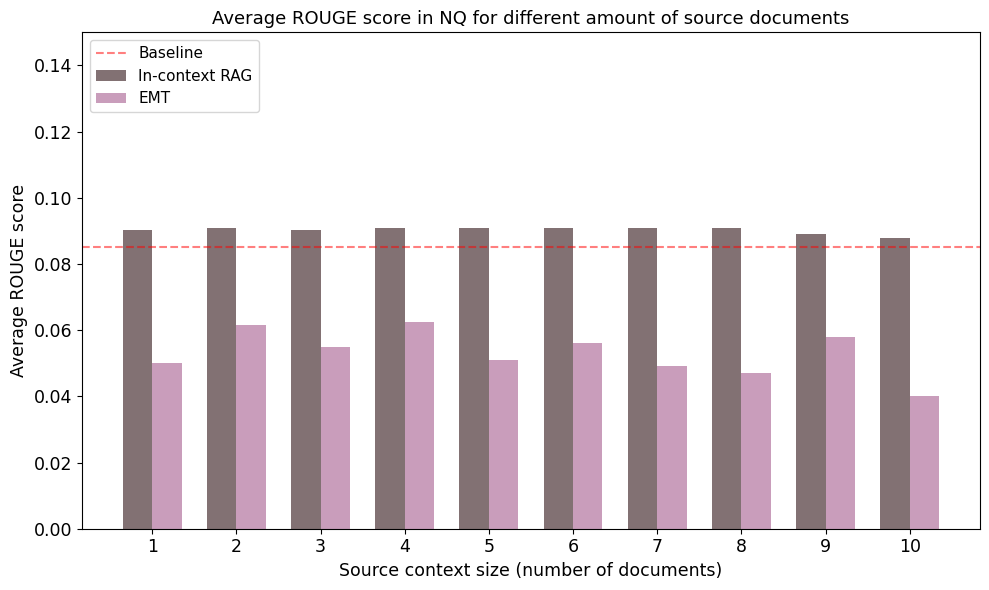

Mean baseline:  0.08510038055716983
Mean rouge in context RAG:  [0.09026801611788952, 0.09099919891358846, 0.09026801611788952, 0.09099919891358846, 0.09099919891358846, 0.09099919891358846, 0.09099919891358846, 0.09099919891358846, 0.08918101709540663, 0.08792683049253583]
[0.09026801611788952, 0.09099919891358846, 0.09026801611788952, 0.09099919891358846, 0.09099919891358846, 0.09099919891358846, 0.09099919891358846, 0.09099919891358846, 0.08918101709540663, 0.08792683049253583]
Sds rouge in context RAG:  [0.12413939830858414, 0.1249582013034579, 0.12413939830858414, 0.1249582013034579, 0.1249582013034579, 0.1249582013034579, 0.1249582013034579, 0.1249582013034579, 0.12494628427185196, 0.12167342502504286]
[0.12413939830858414, 0.1249582013034579, 0.12413939830858414, 0.1249582013034579, 0.1249582013034579, 0.1249582013034579, 0.1249582013034579, 0.1249582013034579, 0.12494628427185196, 0.12167342502504286]

Mean rouge for EMT:  [0.09026801611788952, 0.09099919891358846, 0.0902680161

In [3]:
# Define directories
dirs = ['results/n_documents/RAG/3', 'results/n_documents/EMT/3']
ylim = 0.15

color_1="#3F2528"
color_2="#AC6997"
opacity = 0.65
# Initialize lists to store data
n_memories_list = []
rouge_mean_memories_list = []
sds = []

# Loop over directories
for data_dir in dirs:
    combined, df = aggregate_scores(data_dir, measures=['bleu', 'rouge'], group_by='top_k')  
    df = df[~df['predicted'].isna()]
    df['rouge_max'] = df.apply(lambda row: calculate_rouge(row['gold'], row['predicted']),axis=1)

    n_memories, rouge_mean_memories, sd = calculate_mean_sd(df, 'n_retrieval_docs', 'rouge_max')
    
    # Append data to lists
    n_memories_list.append(n_memories)
    rouge_mean_memories_list.append(rouge_mean_memories)
    sds.append(sd)
# Set the figure size
plt.figure(figsize=(10, 6))

# Set the bar width and positions
bar_width = 0.35
index_1 = np.arange(len(n_memories_list[0]))
index_2 = index_1 + bar_width

# Plot the first list
plt.bar(index_1,
        rouge_mean_memories_list[0], 
        # error bars
        bar_width, 
        color=color_1, 
        alpha=opacity,
        capsize=3,
        label='In-context RAG')

# Plot the second list next to the first
plt.bar(index_2, 
        rouge_mean_memories_list[1], 
        bar_width, 
        color=color_2, 
        alpha=opacity, 
        label='EMT')

# Set the x-ticks
plt.xticks(index_1 + bar_width / 2, n_memories_list[0], fontsize=axes_size)
plt.axhline(y=rouge_mean_baseline, color='r', linestyle='dashed', alpha=0.5, label='Baseline')
plt.xlabel(r'Source context size (number of documents)', fontsize=axes_size)
plt.ylabel(r'Average ROUGE score', fontsize=axes_size)
plt.title(r'Average ROUGE score in NQ for different amount of source documents', fontsize=title_size)
plt.yticks(fontsize=axes_size)
plt.ylim(0,ylim)
plt.legend(loc='upper left', fontsize=legend_size)
plt.grid(False)
plt.tight_layout()
plt.show()

print("Mean baseline: ", rouge_mean_baseline)

print("Mean rouge in context RAG: ", rouge_mean_memories_list[0])
print(rouge_mean_memories_list[0])
print("Sds rouge in context RAG: ", sds[0])
print(sds[0])
print()
print("Mean rouge for EMT: ", rouge_mean_memories_list[0])
print(rouge_mean_memories_list[1])
print("Sds rouge in EMT: ", sds[0])
print(sds[1])

# Calculate relationship between cosine similarity and ROUGE

/var/folders/f0/_dxvrvyj2bz3nx15v32xm7zh0000gq/T/ipykernel_9067/1678013003.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['rouge_max'] = df.apply(lambda row: calculate_rouge(row['gold'], row['predicted']),axis=1)
/var/folders/f0/_dxvrvyj2bz3nx15v32xm7zh0000gq/T/ipykernel_9067/1678013003.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['similarities'] = df['similarities'].apply(lambda x: x.split(',') if isinstance(x, str) else x)


Pearson correlation: 0.10949438197170022
Scipy Pearson correlation: PearsonRResult(statistic=0.10949438197170025, pvalue=0.28064716527577405)


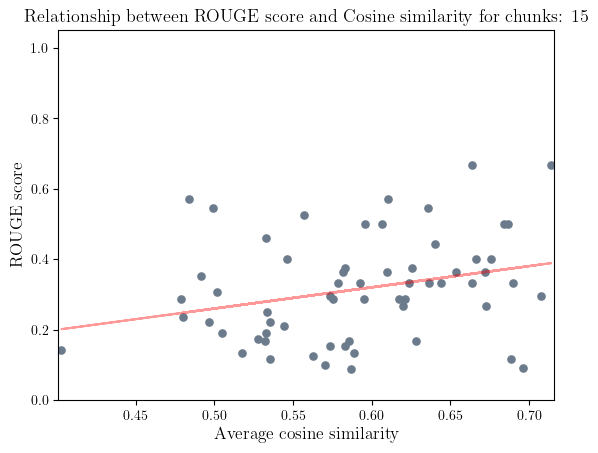

Pearson correlation: 0.14895411826922805
Scipy Pearson correlation: PearsonRResult(statistic=0.14895411826922805, pvalue=0.13911927580837735)


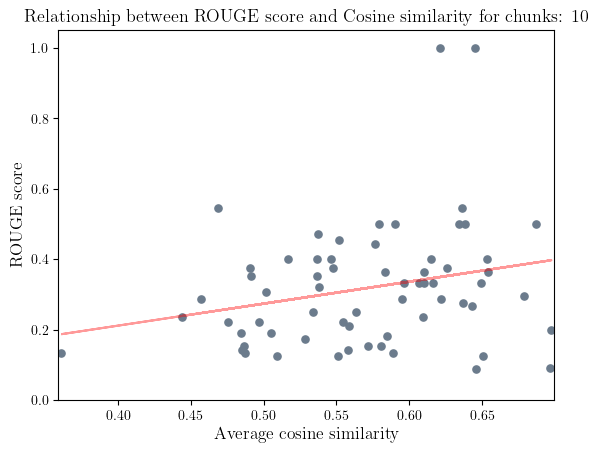

Pearson correlation: 0.008542182722597247
Scipy Pearson correlation: PearsonRResult(statistic=0.008542182722597276, pvalue=0.9327786442309914)


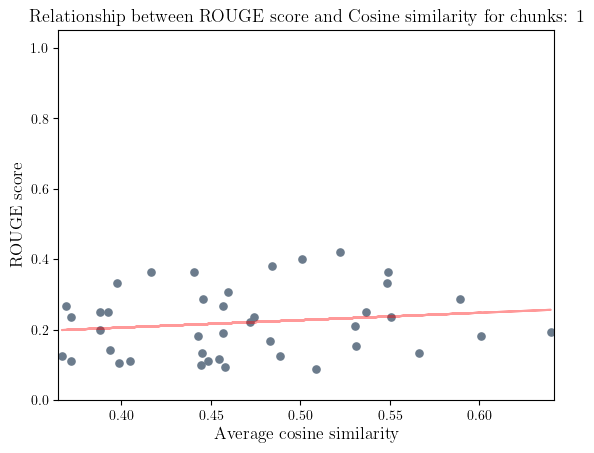

Pearson correlation: 0.12989239945811717
Scipy Pearson correlation: PearsonRResult(statistic=0.1298923994581172, pvalue=0.19772584643865437)


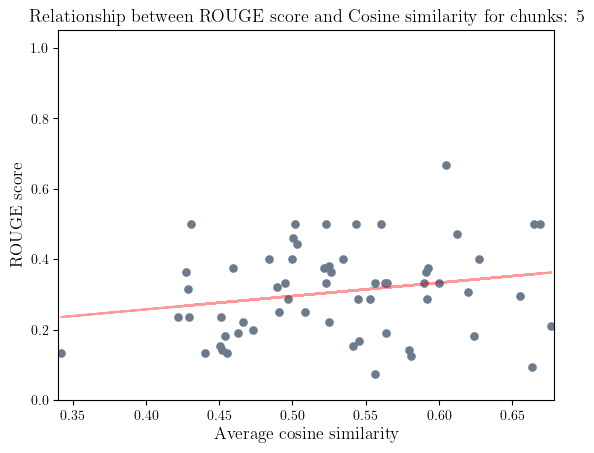

Pearson correlation: 0.14954009583602418
Scipy Pearson correlation: PearsonRResult(statistic=0.14954009583602415, pvalue=0.13755347724014014)


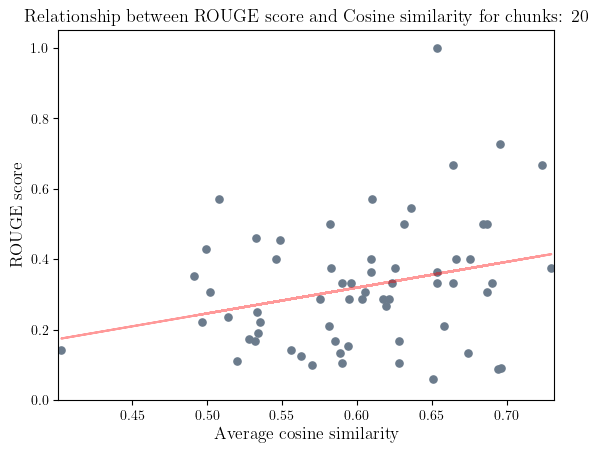

Pearson correlation: 0.005640999949707997
Scipy Pearson correlation: PearsonRResult(statistic=0.005640999949707966, pvalue=0.955579826643703)


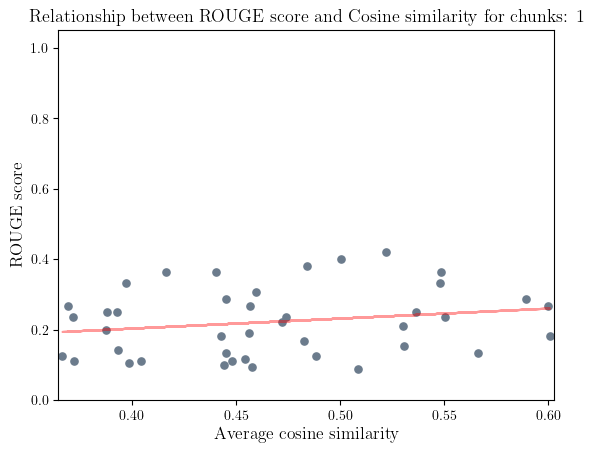

Pearson correlation: 0.028108985506394017
Scipy Pearson correlation: PearsonRResult(statistic=0.028108985506393996, pvalue=0.7824071775858258)


/var/folders/f0/_dxvrvyj2bz3nx15v32xm7zh0000gq/T/ipykernel_9067/1678013003.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['rouge_max'] = df.apply(lambda row: calculate_rouge(row['gold'], row['predicted']),axis=1)
/var/folders/f0/_dxvrvyj2bz3nx15v32xm7zh0000gq/T/ipykernel_9067/1678013003.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['similarities'] = df['similarities'].apply(lambda x: x.split(',') if isinstance(x, str) else x)


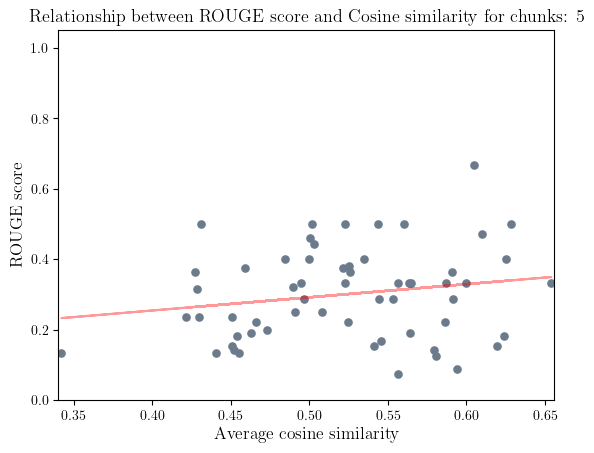

/var/folders/f0/_dxvrvyj2bz3nx15v32xm7zh0000gq/T/ipykernel_9067/1678013003.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['rouge_max'] = df.apply(lambda row: calculate_rouge(row['gold'], row['predicted']),axis=1)
/var/folders/f0/_dxvrvyj2bz3nx15v32xm7zh0000gq/T/ipykernel_9067/1678013003.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['similarities'] = df['similarities'].apply(lambda x: x.split(',') if isinstance(x, str) else x)


Pearson correlation: 0.15857855567219575
Scipy Pearson correlation: PearsonRResult(statistic=0.15857855567219573, pvalue=0.11885641373376621)


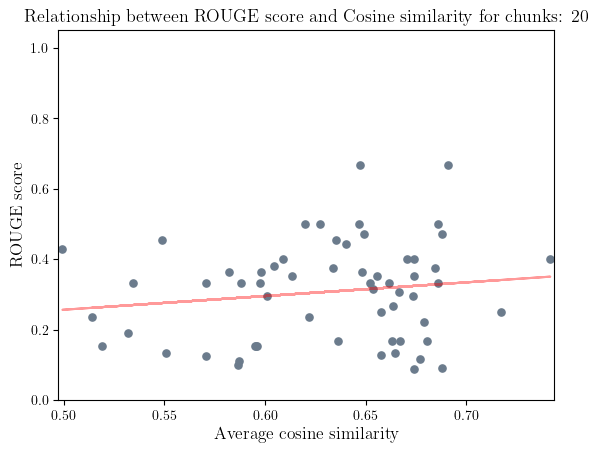

Pearson correlation: 0.11728858791144507
Scipy Pearson correlation: PearsonRResult(statistic=0.11728858791144516, pvalue=0.24517208730221)


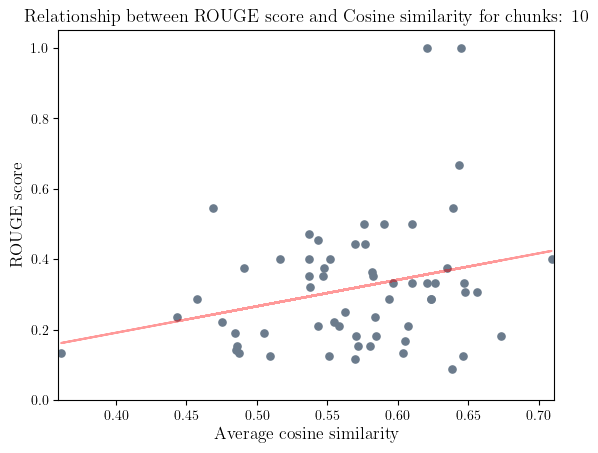

Pearson correlation: 0.20637787611481878
Scipy Pearson correlation: PearsonRResult(statistic=0.20637787611481861, pvalue=0.0404158087738402)


/var/folders/f0/_dxvrvyj2bz3nx15v32xm7zh0000gq/T/ipykernel_9067/1678013003.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['rouge_max'] = df.apply(lambda row: calculate_rouge(row['gold'], row['predicted']),axis=1)
/var/folders/f0/_dxvrvyj2bz3nx15v32xm7zh0000gq/T/ipykernel_9067/1678013003.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['similarities'] = df['similarities'].apply(lambda x: x.split(',') if isinstance(x, str) else x)


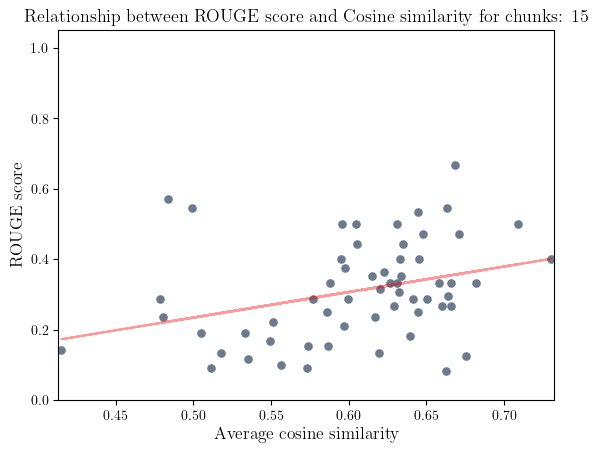

In [4]:
dir = "results/n_chunks/NQ/4/1docs/"

files = os.listdir(dir)
# select all the files that end with csv
files = [f for f in files if f.endswith('.csv')]
for i in files:
    df = pd.read_csv(os.path.join(dir, i), encoding='latin-1') 
    plot_rouge_cosine_similarity(df)


dir = "results/n_chunks/NQ/4/5docs/"
files = os.listdir(dir)
# select all the files that end with csv
files = [f for f in files if f.endswith('.csv')]
for i in files:
    df = pd.read_csv(os.path.join(dir, i), encoding='latin-1') 
    plot_rouge_cosine_similarity(df)





# Results in in-context RAG and EMT with NQ as context size increases

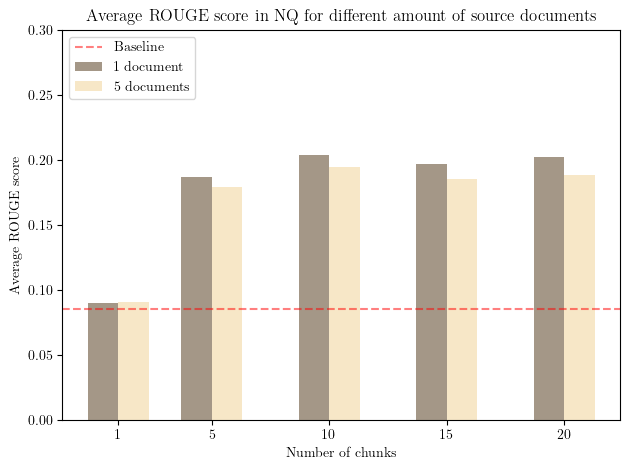

Mean baseline:  0.08510038055716983
Mean rouge in context RAG:  [0.09026801611788952, 0.09099919891358846, 0.09026801611788952, 0.09099919891358846, 0.09099919891358846, 0.09099919891358846, 0.09099919891358846, 0.09099919891358846, 0.08918101709540663, 0.08792683049253583]
[0.09026801611788952, 0.09099919891358846, 0.09026801611788952, 0.09099919891358846, 0.09099919891358846, 0.09099919891358846, 0.09099919891358846, 0.09099919891358846, 0.08918101709540663, 0.08792683049253583]
Sds rouge in context RAG:  [0.12413939830858414, 0.17968005390173347, 0.20636470131896956, 0.1910941439979408, 0.20970036241485923]
[0.12413939830858414, 0.17968005390173347, 0.20636470131896956, 0.1910941439979408, 0.20970036241485923]

Mean rouge for EMT:  [0.09026801611788952, 0.09099919891358846, 0.09026801611788952, 0.09099919891358846, 0.09099919891358846, 0.09099919891358846, 0.09099919891358846, 0.09099919891358846, 0.08918101709540663, 0.08792683049253583]
[0.05021964472257177, 0.06143982324000069, 0

In [5]:
dirs = ["results/n_chunks/NQ/4/1docs", "results/n_chunks/NQ/4/5docs"]
ylim = 0.30

# Initialize lists to store data
n_chunks_list = []
rouge_mean_chunks_list = []
sds = []

for i in dirs:
    sds_t=[]
    means_t=[]
    chunks = []
    # Read each of them, duplicate the top-k column
    wandb_exp_files = [f for f in os.listdir(i) if f.endswith('.csv')]
    for idx, l in enumerate(wandb_exp_files):
        temp = pd.read_csv(os.path.join(i, l), encoding='latin-1')
        temp = temp[~temp['predicted'].isna()]
        temp['actual_top_k'] = temp['top_k']
        temp['top_k'] = temp['top_k'].max()

        temp['rouge_max'] = temp.apply(lambda row: calculate_rouge(row['gold'], row['predicted']),axis=1)
        mean = temp['rouge_max'].mean()
        sd = temp['rouge_max'].std()
        means_t.append(mean)
        sds_t.append(sd)
        chunks.append(temp['top_k'].iloc[0])

        if idx == 0:
            df = temp
        else:
            df = pd.concat([df, temp])

        
    n_chunks, rouge_mean_chunks, sd = calculate_mean_sd(df, 'top_k', 'rouge_max')
    
    # Append data to lists
    n_chunks_list.append(n_chunks)
    rouge_mean_chunks_list.append(rouge_mean_chunks)
    sds.append(sd)

# Create bar plot
bar_width = 1.3
opacity = 0.8

index = n_chunks_list[0]

fig, ax = plt.subplots()

bar1 = plt.bar(index, 
               rouge_mean_chunks_list[0],
               bar_width, 
               alpha=opacity, 
               color= "#8e7d69",
               label='1 document')

bar2 = plt.bar(index + bar_width, 
               rouge_mean_chunks_list[1], 
               bar_width, 
               alpha=opacity, 
               color= "#f5e1b9",
               label='5 documents')
plt.axhline(y=rouge_mean_baseline, color='r', linestyle='dashed', alpha=0.5, label='Baseline')
plt.xlabel(r'Number of chunks')
plt.ylabel(r'Average ROUGE score')
plt.title(r'Average ROUGE score in NQ for different amount of source documents')
plt.xticks(index + bar_width / 2, [r'$%d$' % int(n) for n in n_chunks_list[0]],)
plt.yticks()
plt.ylim(0,ylim)
plt.legend(loc='upper left')
plt.grid(False)
plt.tight_layout()
plt.show()



print("Mean baseline: ", rouge_mean_baseline)

print("Mean rouge in context RAG: ", rouge_mean_memories_list[0])
print(rouge_mean_memories_list[0])
print("Sds rouge in context RAG: ", sds[0])
print(sds[0])
print()
print("Mean rouge for EMT: ", rouge_mean_memories_list[0])
print(rouge_mean_memories_list[1])
print("Sds rouge in EMT: ", sds[0])
print(sds[1])



['wandb_export_2024-04-27T19_19_29.471+02_00.csv', 'wandb_export_2024-04-29T11_35_39.290+02_00.csv', '.DS_Store', 'wandb_export_2024-04-27T19_19_51.613+02_00.csv', 'wandb_export_2024-04-29T11_35_53.491+02_00.csv', 'AdditionalKs', 'wandb_export_2024-05-05T15_49_49.900+02_00.csv', 'wandb_export_2024-05-05T15_50_04.220+02_00.csv', 'wandb_export_2024-04-29T11_36_04.020+02_00.csv']
['.DS_Store', 'wandb_export_2024-04-28T22_21_11.183+02_00.csv', 'wandb_export_2024-04-28T22_20_58.994+02_00.csv', 'wandb_export_2024-04-29T08_09_32.229+02_00.csv', 'wandb_export_2024-05-05T15_49_37.913+02_00.csv', 'wandb_export_2024-04-29T08_09_19.788+02_00.csv', 'wandb_export_2024-04-29T08_09_44.334+02_00.csv', 'wandb_export_2024-05-05T15_49_18.341+02_00.csv']


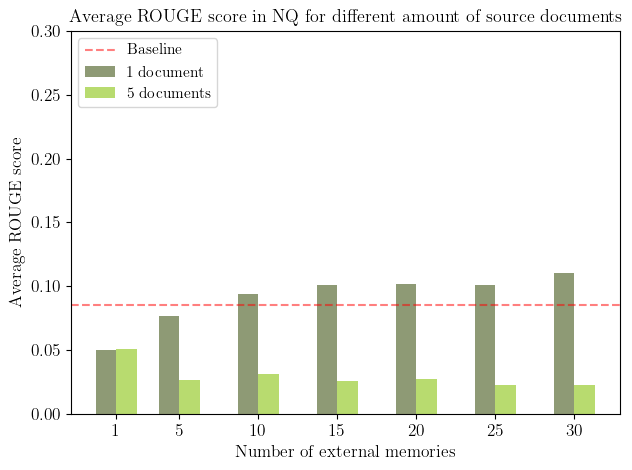

Mean baseline:  0.08510038055716983
Mean rouge in context RAG:  [0.05021964472257177, 0.07653439356543408, 0.09374482209362293, 0.10104219882509019, 0.10175885524171736, 0.10133157548411263, 0.11071956872207787]
[0.05021964472257177, 0.07653439356543408, 0.09374482209362293, 0.10104219882509019, 0.10175885524171736, 0.10133157548411263, 0.11071956872207787]
Sds rouge in context RAG:  [0.08514102093499304, 0.11597766015687452, 0.1293580633370375, 0.1421392123463837, 0.14145559566777177, 0.137140660186401, 0.12739687960010562]
[0.08514102093499304, 0.11597766015687452, 0.1293580633370375, 0.1421392123463837, 0.14145559566777177, 0.137140660186401, 0.12739687960010562]

Mean rouge for EMT:  [0.05021964472257177, 0.07653439356543408, 0.09374482209362293, 0.10104219882509019, 0.10175885524171736, 0.10133157548411263, 0.11071956872207787]
[0.05086441714780464, 0.026317100301392025, 0.031525698605312666, 0.02605836806612568, 0.02723074929398191, 0.023075203447139585, 0.022577574842370076]
Sds

In [6]:
# Define directories
dirs = ["results/n_memories/NQ/1docs", "results/n_memories/NQ/5docs"]
ylim = 0.30
color1 = "#5f6f3a"
color2 = "#9acd32"
# Initialize lists to store data
n_memories_list = []
rouge_mean_memories_list = []
sds = []

all_emt = pd.DataFrame()
# Loop over directories
for data_dir in dirs:
    combined, df = aggregate_scores(data_dir, measures=['bleu', 'rouge'], group_by='top_k')  
    df = df[~df['predicted'].isna()]
    df['rouge_max'] = df.apply(lambda row: calculate_rouge(row['gold'], row['predicted']),axis=1)

    n_memories, rouge_mean_memories, sd = calculate_mean_sd(df, 'top_k', 'rouge_max')
    
    # Append data to lists
    n_memories_list.append(n_memories)
    rouge_mean_memories_list.append(rouge_mean_memories)
    sds.append(sd)

    all_emt = pd.concat([all_emt, df])

# Create bar plot
bar_width = 1.3
opacity = 0.7

index = n_memories_list[0] #[:-1] #np.arange(len(n_memories_list[0]))
fig, ax = plt.subplots()

bar1 = plt.bar(index, 
               rouge_mean_memories_list[0],#[:-1], 
               bar_width, 
               alpha=opacity, 
               color= color1,#"#6d9c3f", #'sandybrown', 
               label='1 document')

bar2 = plt.bar(index + bar_width, 
               rouge_mean_memories_list[1], 
               bar_width, 
               alpha=opacity, 
               color= color2, #"#7fb53f", #'purple', 
               label='5 documents')
plt.axhline(y=rouge_mean_baseline, color='r', linestyle='dashed', alpha=0.5, label='Baseline')
plt.xlabel('Number of external memories', fontsize=axes_size)
plt.ylabel('Average ROUGE score', fontsize=axes_size)
plt.title('Average ROUGE score in NQ for different amount of source documents', fontsize=title_size)
plt.xticks(index + bar_width / 2, [r'$%d$' % int(n) for n in n_memories_list[0]], fontsize=axes_size)
plt.yticks(fontsize=axes_size)
plt.ylim(0,ylim)
plt.legend(loc='upper left', fontsize=legend_size)
plt.grid(False)
plt.tight_layout()
plt.show()

# Green for EMT
# Brown for RAG

print("Mean baseline: ", rouge_mean_baseline)

print("Mean rouge in context RAG: ", rouge_mean_memories_list[0])
print(rouge_mean_memories_list[0])
print("Sds rouge in context RAG: ", sds[0])
print(sds[0])
print()
print("Mean rouge for EMT: ", rouge_mean_memories_list[0])
print(rouge_mean_memories_list[1])
print("Sds rouge in EMT: ", sds[0])
print(sds[1])

print(sds)

# Results in in-context RAG and EMT with QuALITY as context size increases

In [7]:
# Baseline agains the best of the models 
data_dir = 'results/baselines/QuALITY/wandb_export_2024-05-01T12_34_13.386+02_00.csv'
# Read the data and take whatever file that ends with csv
baseline = pd.read_csv(os.path.join(data_dir), encoding='latin-1', index_col=False)
# Remove the following rows
baseline = baseline[~baseline['predicted'].isna()]

#replace the above with the emt df
baseline['predicted_numbers'] = [re.findall(r'\d+', i) for i in baseline['predicted'] if isinstance(i, str)]
baseline['gold'] = baseline['gold'].astype(int).astype(str)
baseline['in_predicted'] = baseline.apply(lambda row: 0 if len(row['predicted_numbers']) > 3 else (1/len(row['predicted_numbers']) if row['gold'] in row['predicted_numbers'] else 0), axis=1)


accuracy_baseline = sum(baseline['in_predicted'])/len(baseline)
print("Mean baseline: ", baseline['in_predicted'].mean())
print("SD baseline: ", baseline['in_predicted'].std())

Mean baseline:  0.16666666666666663
SD baseline:  0.36159641049835856


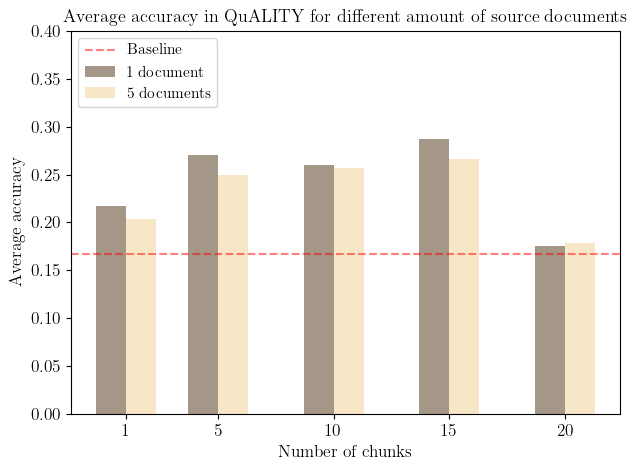

Mean accuracy in-context RAG 1 doc:  [0.21666666666666665, 0.26999999999999996, 0.25999999999999995, 0.2866666666666667, 0.175]
SD in-context RAG 1 doc:  [0.3830734003798271, 0.40878402256494456, 0.41324860650026485, 0.4381370622275849, 0.35563051608806573]
Mean accuracy in-context RAG 5 doc:  [0.20333333333333328, 0.25, 0.25666666666666665, 0.26666666666666666, 0.17833333333333334]
SD in-context RAG 1 doc:  [0.36666666666666664, 0.3903292230373001, 0.4078494693811959, 0.42771546181293196, 0.3578955512286029]


In [8]:
# Define directories
dirs = ["results/n_chunks/QuALITY/3/1docs", "results/n_chunks/QuALITY/3/5docs"]

color1="#8e7d69"
color2="#f5e1b9"
ylim = 0.40
# Initialize lists to store data
n_chunks_list = []
acc_mean_chunks_list = []
sds = []


for i in dirs:
    sds_t=[]
    acc=[]
    # Read each of them, duplicate the top-k column
    wandb_exp_files = [f for f in os.listdir(i) if f.endswith('.csv')]
    for idx, l in enumerate(wandb_exp_files):    
        temp = pd.read_csv(os.path.join(i, l), encoding='latin-1')
        temp = temp[~temp['predicted'].isna()]
        temp['actual_top_k'] = temp['top_k']
        temp['top_k'] = temp['top_k'].max()
        calculate_in_predicted(temp)

        
        if idx == 0:
            df = temp
        else:
            df = pd.concat([df, temp])

    n_chunks = df['top_k'].unique()
    # Sort the top_k
    var_sorted = np.sort(n_chunks)

    for k in var_sorted:
        sub = df[df['top_k'] == k]
        acc.append(sum(sub['in_predicted'])/len(sub))
        sds_t.append(sub['in_predicted'].std())

    # Append data to lists
    n_chunks_list.append(var_sorted)
    acc_mean_chunks_list.append(acc)
    sds.append(sds_t)


# Create bar plot
bar_width = 1.3
opacity = 0.8

index = n_chunks_list[0] #[:-1] #np.arange(len(n_memories_list[0]))
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Computer Modern Roman"
})
plt.rcParams['text.usetex'] = True
    
axes_size = 12.5
title_size = 13
legend_size = 11


fig, ax = plt.subplots()

bar1 = plt.bar(index, 
               acc_mean_chunks_list[0],#[:-1], 
               bar_width, 
               alpha=opacity, 
               color= color1, #'sandybrown', "#733B1A",#BF926B"
               label='1 document')

bar2 = plt.bar(index + bar_width, 
               acc_mean_chunks_list[1], 
               bar_width, 
               alpha=opacity, 
               color= color2, #"#7fb53f", #'purple', 
               label='5 documents')

plt.axhline(y=accuracy_baseline, color='r', linestyle='dashed', alpha=0.5, label='Baseline')
plt.xlabel(r'Number of chunks', fontsize=axes_size)
plt.ylabel(r'Average accuracy', fontsize=axes_size)
plt.title(r'Average accuracy in QuALITY for different amount of source documents', fontsize=title_size)
#plt.xticks(index + bar_width / 2, [int(n) for n in n_memories_list[0]]) 
plt.xticks(index + bar_width / 2, [r'$%d$' % int(n) for n in n_chunks_list[0]], fontsize=axes_size)
plt.yticks(fontsize=axes_size)
plt.ylim(0,ylim)
plt.legend(loc='upper left', fontsize=legend_size)
plt.grid(False)
plt.tight_layout()
plt.show()

print("Mean accuracy in-context RAG 1 doc: ", acc_mean_chunks_list[0])
print("SD in-context RAG 1 doc: ", sds[0])

print("Mean accuracy in-context RAG 5 doc: ", acc_mean_chunks_list[1])
print("SD in-context RAG 1 doc: ", sds[1])


10
0.17833333333333334
20
0.17833333333333334
15
0.17833333333333334
30
0.17833333333333334
5
0.17833333333333334
1
0.17833333333333334
25
0.17833333333333334
1
0.20166666666666663
10
0.20166666666666663
20
0.20166666666666663
5
0.20166666666666663
15
0.20166666666666663
15
0.20166666666666663
25
0.20166666666666663
30
0.20166666666666663


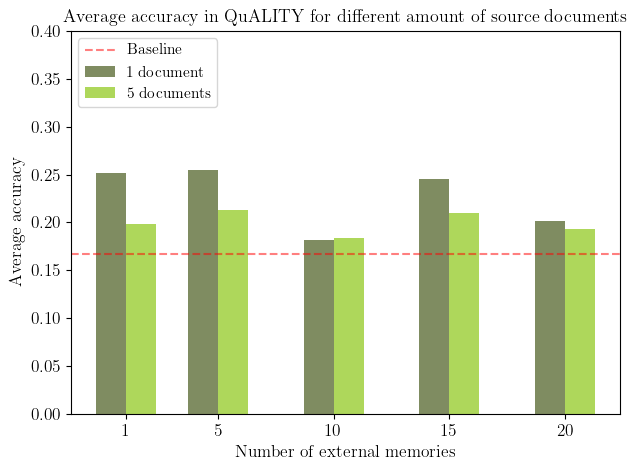

Mean accuracy EMT 1 doc:  [0.2516666666666666, 0.255, 0.18166666666666664, 0.245, 0.20166666666666663]
SD accuracy EMT 1 doc:  [0.40790106302461454, 0.4092470708302809, 0.3716186875464988, 0.4092470708302809, 0.3880185065067061]
Mean accuracy EMT 5 doc:  [0.2516666666666666, 0.255, 0.18166666666666664, 0.245, 0.20166666666666663]
SD accuracy EMT 5 doc:  [0.40790106302461454, 0.4092470708302809, 0.3716186875464988, 0.4092470708302809, 0.3880185065067061]


In [9]:
# Define directories
dirs = ["results/n_memories/QuALITY/3/1docs", "results/n_memories/QuALITY/3/5docs"]
ylim = 0.40

color1 = "#5f6f3a"
color2 = "#9acd32"

# Initialize lists to store data
n_chunks_list = []
acc_mean_chunks_list = []
sds = []

for i in dirs:
    sds_t=[]
    acc=[]
    # Read each of them, duplicate the top-k column
    wandb_exp_files = [f for f in os.listdir(i) if f.endswith('.csv')]
    for idx, l in enumerate(wandb_exp_files):    
        temp = pd.read_csv(os.path.join(i, l), encoding='latin-1')
        temp = temp[~temp['predicted'].isna()]
        temp['actual_top_k'] = temp['top_k']
        temp['top_k'] = temp['top_k'].max()
        calculate_in_predicted(temp)
        print(temp['top_k'].iloc[0])
        print(sum(sub['in_predicted'])/len(sub))

        
        if idx == 0:
            df = temp
        else:
            df = pd.concat([df, temp])

    # Sort the top_k
    var_sorted = np.sort(n_chunks)


    for k in var_sorted:
        sub = df[df['top_k'] == k]
        acc.append(sum(sub['in_predicted'])/len(sub))
        sds_t.append(sub['in_predicted'].std())

    # Append data to lists
    n_chunks_list.append(var_sorted)
    acc_mean_chunks_list.append(acc)
    sds.append(sds_t)



# Create bar plot
bar_width = 1.3
opacity = 0.8

index = n_chunks_list[0] #[:-1] #np.arange(len(n_memories_list[0]))
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Computer Modern Roman"
})
plt.rcParams['text.usetex'] = True
    
axes_size = 12.5
title_size = 13
legend_size = 11

fig, ax = plt.subplots()

bar1 = plt.bar(index, 
               acc_mean_chunks_list[0],#[:-1], 
               bar_width, 
               alpha=opacity, 
               color= color1, #'sandybrown', "#733B1A",#BF926B"
               label='1 document')

bar2 = plt.bar(index + bar_width, 
               acc_mean_chunks_list[1], 
               bar_width, 
               alpha=opacity, 
               color= color2, #"#7fb53f", #'purple', 
               label='5 documents')

plt.axhline(y=accuracy_baseline, color='r', linestyle='dashed', alpha=0.5, label='Baseline')
plt.xlabel('Number of external memories', fontsize=axes_size)
plt.ylabel('Average accuracy', fontsize=axes_size)
plt.title('Average accuracy in QuALITY for different amount of source documents', fontsize=title_size)
plt.xticks(index + bar_width / 2, [r'$%d$' % int(n) for n in n_chunks_list[0]], fontsize=axes_size)
plt.yticks(fontsize=axes_size)
plt.ylim(0,ylim)
plt.legend(loc='upper left', fontsize=legend_size)
plt.grid(False)
plt.tight_layout()
plt.show()

print("Mean accuracy EMT 1 doc: ", acc_mean_chunks_list[0])
print("SD accuracy EMT 1 doc: ", sds[0])

print("Mean accuracy EMT 5 doc: ", acc_mean_chunks_list[0])
print("SD accuracy EMT 5 doc: ", sds[0])

## Perplexity
* From initial experiments, it seems like perplexity drops in RAG when we add a the answer in the context window (look in check_perplexity notebook)
* Is this the same for EMT when we 
* Perform perplexity experiments for RAG with 1, 5 and 15 chunks
* Perform perplexity experiments for EMT with ? memories 


In [10]:
# Start with baseline
baseline_perp = os.listdir('results/perplexity/baseline/NQ')[0]
baseline_perp = pd.read_csv('results/perplexity/baseline/NQ/'+baseline_perp)
baseline_perp_nq = baseline_perp['perplexity'].mean()

# Start with baseline
baseline_perp = os.listdir('results/perplexity/baseline/QuALITY')[0]
baseline_perp = pd.read_csv('results/perplexity/baseline/QuALITY/'+baseline_perp)
baseline_perp_q = baseline_perp['perplexity'].mean()


['wandb_export_2024-05-07T21_54_08.896+02_00.csv', 'wandb_export_2024-05-08T07_10_06.134+02_00.csv', 'wandb_export_2024-05-09T16_35_32.520+02_00.csv', 'wandb_export_2024-05-09T11_52_01.060+02_00.csv', 'wandb_export_2024-05-09T11_51_45.183+02_00.csv', 'wandb_export_2024-05-09T11_51_27.330+02_00.csv']
['wandb_export_2024-05-08T20_23_18.721+02_00.csv', 'wandb_export_2024-05-08T20_22_38.895+02_00.csv', 'wandb_export_2024-05-08T20_23_33.545+02_00.csv', 'wandb_export_2024-05-08T20_22_27.030+02_00.csv', 'wandb_export_2024-05-08T20_22_13.361+02_00.csv', 'wandb_export_2024-05-08T20_22_57.707+02_00.csv']
Perplexity baseline NQ:  80.77278046131134
Perplexity in-context RAG 1 docs:  [20.63833713054657, 12.999127221107482, 11.505687355995178, 10.939746270179748, 10.807074584960937, 10.973682465553283]
Perplexity in-context RAG 5 docs:  [20.655249276161193, 12.9418803358078, 11.855616121292114, 11.639210619926452, 11.604873118400574, 11.61099967956543]


<Figure size 1000x600 with 0 Axes>

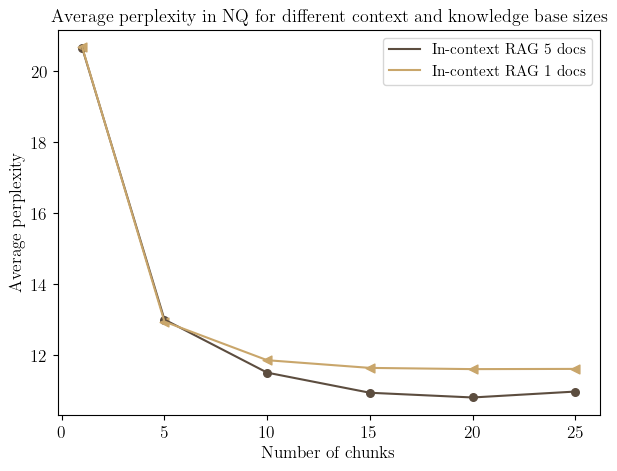

In [11]:
dirs = ['results/perplexity/rag/NQ/5docs', 'results/perplexity/rag/NQ/1docs']
color1="#5c4d3f"
color2="#c9a66b"
color3="red"
n_chunks_list = []
perplexity_list = []
sds = []
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Computer Modern Roman"
})
plt.rcParams['text.usetex'] = True
    
axes_size = 12.5
title_size = 13
legend_size = 11

plt.figure(figsize=(10, 6))

# Loop over directories
for data_dir in dirs:
    combined, df = aggregate_scores(data_dir, measures=['perplexity'], group_by='top_k')  

    n_chunks, perp, sd = calculate_mean_sd(df, 'top_k', 'perplexity')
    
    # Append data to lists
    n_chunks_list.append(n_chunks)
    perplexity_list.append(perp)
    sds.append(sd)
plt.figure(figsize=(7, 5))

# Plot the lines
plt.plot(n_chunks_list[0], perplexity_list[0], label='In-context RAG 5 docs', color=color1)
plt.plot(n_chunks_list[1], perplexity_list[1], label='In-context RAG 1 docs', color=color2)

# Add scatter points for the first line
plt.scatter(n_chunks_list[0], perplexity_list[0], color=color1, marker='o', s=30,  alpha=1)

# Add scatter points for the second line
plt.scatter(n_chunks_list[1], perplexity_list[1], color=color2, marker='<', s=40,  alpha=1)

#plt.axhline(y=baseline_perp, color=color3, linestyle='dashed', alpha=0.5, label='Baseline')
plt.legend(fontsize=legend_size)
plt.xlabel('Number of chunks', fontsize=axes_size)
plt.ylabel('Average perplexity', fontsize=axes_size)
plt.title('Average perplexity in NQ for different context and knowledge base sizes', fontsize=title_size)
plt.xticks(fontsize=axes_size)
plt.yticks(fontsize=axes_size)

print("Perplexity baseline NQ: ", baseline_perp_nq)
print("Perplexity in-context RAG 1 docs: ", perplexity_list[0])
print("Perplexity in-context RAG 5 docs: ", perplexity_list[1])

['wandb_export_2024-05-13T15_02_22.744+02_00.csv', 'wandb_export_2024-05-13T15_01_16.515+02_00.csv', 'wandb_export_2024-05-13T15_01_01.802+02_00.csv', 'wandb_export_2024-05-13T15_01_39.513+02_00.csv', 'wandb_export_2024-05-13T15_02_05.649+02_00.csv']
['wandb_export_2024-05-13T14_59_57.205+02_00.csv', 'wandb_export_2024-05-13T15_00_21.803+02_00.csv', 'wandb_export_2024-05-13T15_00_32.576+02_00.csv', 'wandb_export_2024-05-13T14_59_44.312+02_00.csv', 'wandb_export_2024-05-13T15_00_10.741+02_00.csv']
Perplexity baseline QuALITY:  80.77278046131134
Perplexity in-context RAG 1 docs:  [40.907568340301516, 24.48434660434723, 21.331405391693114, 19.996676721572875, 19.131133584976197]
Perplexity in-context RAG 5 docs:  [40.7623401260376, 26.565703792572023, 22.659194784164427, 21.423740911483765, 20.66826739311218]


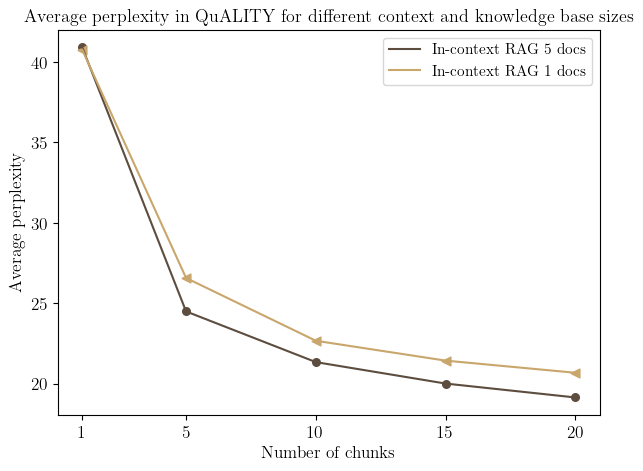

In [12]:
dirs = ['results/perplexity/rag/QuALITY/5docs', 'results/perplexity/rag/QuALITY/1docs']
color1="#5c4d3f"
color2="#c9a66b"
color3="red"
n_chunks_list = []
perplexity_list = []
sds = []

# Loop over directories
for data_dir in dirs:
    combined, df = aggregate_scores(data_dir, measures=['perplexity'], group_by='top_k')  

    n_chunks, perp, sd = calculate_mean_sd(df, 'top_k', 'perplexity')
    
    # Append data to lists
    n_chunks_list.append(n_chunks)
    perplexity_list.append(perp)
    sds.append(sd)
plt.figure(figsize=(7, 5))

# Plot the lines
plt.plot([int(i) for i in n_chunks_list[0]], perplexity_list[0], label='In-context RAG 5 docs', color=color1)
plt.plot([int(i) for i in n_chunks_list[0]], perplexity_list[1], label='In-context RAG 1 docs', color=color2)

# Add scatter points for the first line
plt.scatter([int(i) for i in n_chunks_list[0]], perplexity_list[0], color=color1, marker='o', s=30,  alpha=1)

# Add scatter points for the second line
plt.scatter([int(i) for i in n_chunks_list[0]], perplexity_list[1], color=color2, marker='<', s=40,  alpha=1)

plt.legend(fontsize=legend_size)
plt.xlabel('Number of chunks', fontsize=axes_size)
plt.ylabel('Average perplexity', fontsize=axes_size)
plt.title('Average perplexity in QuALITY for different context and knowledge base sizes', fontsize=title_size)
plt.xticks([int(i) for i in n_chunks_list[0]], fontsize=axes_size)
plt.yticks(fontsize=axes_size)

print("Perplexity baseline QuALITY: ", baseline_perp_nq)
print("Perplexity in-context RAG 1 docs: ", perplexity_list[0])
print("Perplexity in-context RAG 5 docs: ", perplexity_list[1])

['wandb_export_2024-05-14T06_44_01.686+02_00.csv', '.DS_Store', 'wandb_export_2024-05-14T06_44_41.957+02_00.csv', 'wandb_export_2024-05-14T06_43_38.560+02_00.csv', 'wandb_export_2024-05-14T06_44_27.172+02_00.csv', 'wandb_export_2024-05-14T06_45_53.273+02_00.csv', 'wandb_export_2024-05-14T06_45_03.348+02_00.csv']
['wandb_export_2024-05-13T16_43_14.154+02_00.csv', 'wandb_export_2024-05-13T16_43_27.050+02_00.csv', 'wandb_export_2024-05-13T16_43_02.821+02_00.csv', 'wandb_export_2024-05-14T19_25_30.798+02_00.csv', 'wandb_export_2024-05-13T16_43_40.975+02_00.csv', 'wandb_export_2024-05-13T16_43_55.680+02_00.csv', 'wandb_export_2024-05-14T19_25_51.637+02_00.csv']
Perplexity baseline QuALITY:  80.77278046131134
Perplexity EMT 1 docs:  [188.04443836212158, 285.38529923439023, 406.0922348117828, 438.15421028137206, 503.3764353942871, 558.1373010826111]
Perplexity EMT 5 docs:  [140.10754709243776, 145.22066549301147, 185.22139686584472, 159.5230979537964, 162.4747783279419, 154.7670440673828]


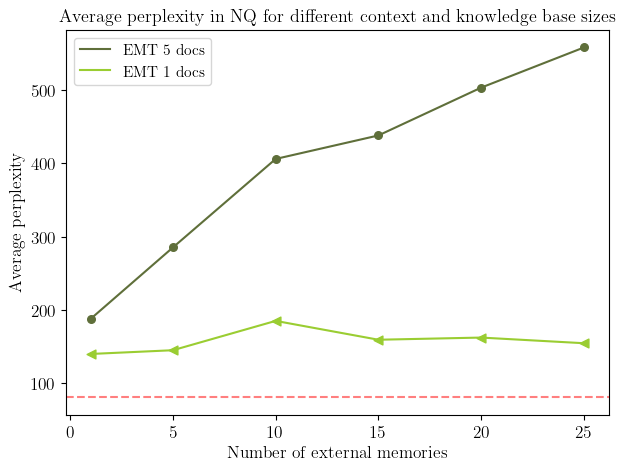

In [13]:
dirs = ['results/perplexity/emt/NQ/5docs/2', 'results/perplexity/emt/NQ/1docs/2']

color1 = "#5f6f3a"
color2 = "#9acd32"


n_chunks_list = []
perplexity_list = []
sds = []

# Loop over directories
for data_dir in dirs:
    combined, df = aggregate_scores(data_dir, measures=['perplexity'], group_by='top_k')  

    n_chunks, perp, sd = calculate_mean_sd(df, 'top_k', 'perplexity')
    # Append data to lists
    n_chunks_list.append(n_chunks)
    perplexity_list.append(perp)
    sds.append(sd)

# Create lineplot with average perplexities
plt.figure(figsize=(7, 5))

# Plot the lines
plt.plot(n_chunks_list[0], perplexity_list[0], label='EMT 5 docs', color=color1)
plt.plot(n_chunks_list[1], perplexity_list[1], label='EMT 1 docs', color=color2)

# Add scatter points for the first line
plt.scatter(n_chunks_list[0], perplexity_list[0], color=color1, marker='o', s=30,  alpha=1)

# Add scatter points for the second line
plt.scatter(n_chunks_list[1], perplexity_list[1], color=color2, marker='<', s=40,  alpha=1)
plt.legend(fontsize=legend_size)
plt.xlabel('Number of external memories', fontsize=axes_size)
plt.ylabel('Average perplexity', fontsize=axes_size)
plt.title('Average perplexity in NQ for different context and knowledge base sizes', fontsize=title_size)
plt.xticks(fontsize=axes_size)
plt.axhline(baseline_perp_nq, color='r', linestyle='dashed', alpha=0.5, label='Baseline')
plt.yticks(fontsize=axes_size)

print("Perplexity baseline QuALITY: ", baseline_perp_nq)
print("Perplexity EMT 1 docs: ", perplexity_list[0])
print("Perplexity EMT 5 docs: ", perplexity_list[1])

results/perplexity/emt/QuALITY/5docs/
['wandb_export_2024-05-14T11_43_23.535+02_00.csv', 'wandb_export_2024-05-14T11_40_27.134+02_00.csv', 'wandb_export_2024-05-14T11_41_39.839+02_00.csv', 'wandb_export_2024-05-14T11_42_35.312+02_00.csv', 'wandb_export_2024-05-14T11_43_01.874+02_00.csv', 'wandb_export_2024-05-14T11_40_47.057+02_00.csv']
results/perplexity/emt/QuALITY/1docs
['wandb_export_2024-05-14T14_53_51.743+02_00.csv', 'wandb_export_2024-05-14T14_54_07.060+02_00.csv', 'wandb_export_2024-05-14T14_54_34.843+02_00.csv', 'wandb_export_2024-05-14T14_54_18.320+02_00.csv', 'wandb_export_2024-05-14T19_10_52.660+02_00.csv', 'wandb_export_2024-05-14T19_11_05.786+02_00.csv']


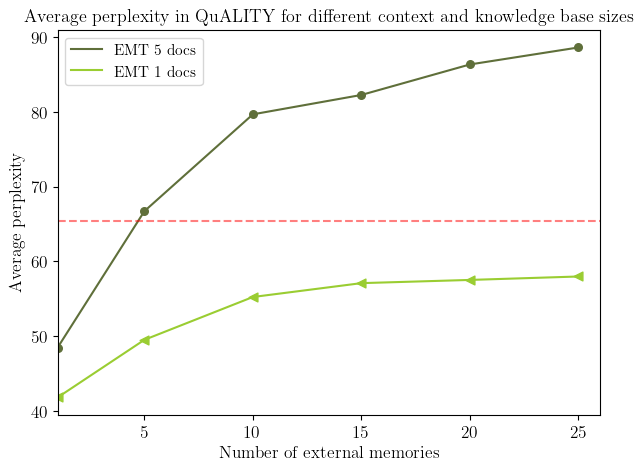

In [14]:
dirs = ['results/perplexity/emt/QuALITY/5docs/', 'results/perplexity/emt/QuALITY/1docs']

color1 = "#5f6f3a"
color2 = "#9acd32"

n_chunks_list = []
perplexity_list = []
sds = []

# Loop over directories
for data_dir in dirs:
    print(data_dir)
    combined, df = aggregate_scores(data_dir, measures=['perplexity'], group_by='top_k')  

    n_chunks, perp, sd = calculate_mean_sd(df, 'top_k', 'perplexity')
    
    # Append data to lists
    n_chunks_list.append(n_chunks)
    perplexity_list.append(perp)
    sds.append(sd)

# Create lineplot with average perplexities
plt.figure(figsize=(7, 5))

# Plot the lines
plt.plot(n_chunks_list[0], perplexity_list[0], label='EMT 5 docs', color=color1)
plt.plot(n_chunks_list[1], perplexity_list[1], label='EMT 1 docs', color=color2)

# Add scatter points for the first line
plt.scatter(n_chunks_list[0], perplexity_list[0], color=color1, marker='o', s=30,  alpha=1)


# Add scatter points for the second line
plt.scatter(n_chunks_list[1], perplexity_list[1], color=color2, marker='<', s=40,  alpha=1)
plt.legend(fontsize=legend_size)
plt.xlabel('Number of external memories', fontsize=axes_size)
plt.ylabel('Average perplexity', fontsize=axes_size)
plt.title('Average perplexity in QuALITY for different context and knowledge base sizes', fontsize=title_size)
plt.xticks(fontsize=axes_size)
plt.yticks(fontsize=axes_size)
plt.xlim(1, 26)
plt.axhline(baseline_perp_q, color='r', linestyle='dashed', alpha=0.5, label='Baseline')

# Qualitative results for QuALITY dataset

In [15]:
# Plot quality questions side by side

rag_dir = "results/n_chunks/QuALITY/3/1docs"
emt_dir = "results/n_memories/QuALITY/3/1docs"

# Read each of them, duplicate the top-k column
wandb_exp_files = [f for f in os.listdir(rag_dir) if f.endswith('.csv')]
for idx, l in enumerate(wandb_exp_files):    
    temp = pd.read_csv(os.path.join(rag_dir, l), encoding='latin-1')
    temp = temp[~temp['predicted'].isna()]
    temp['actual_top_k'] = temp['top_k']
    temp['top_k'] = temp['top_k'].max()
    calculate_in_predicted(temp)

    
    if idx == 0:
        df_rag = temp
    else:
        df_rag = pd.concat([df_rag, temp])


In [16]:

# Read each of them, duplicate the top-k column
wandb_exp_files = [f for f in os.listdir(emt_dir) if f.endswith('.csv')]
for idx, l in enumerate(wandb_exp_files):    
    temp = pd.read_csv(os.path.join(emt_dir, l), encoding='latin-1')
    temp = temp[~temp['predicted'].isna()]
    calculate_in_predicted(temp)

    
    if idx == 0:
        df_emt = temp
    else:
        df_emt = pd.concat([df_emt, temp])

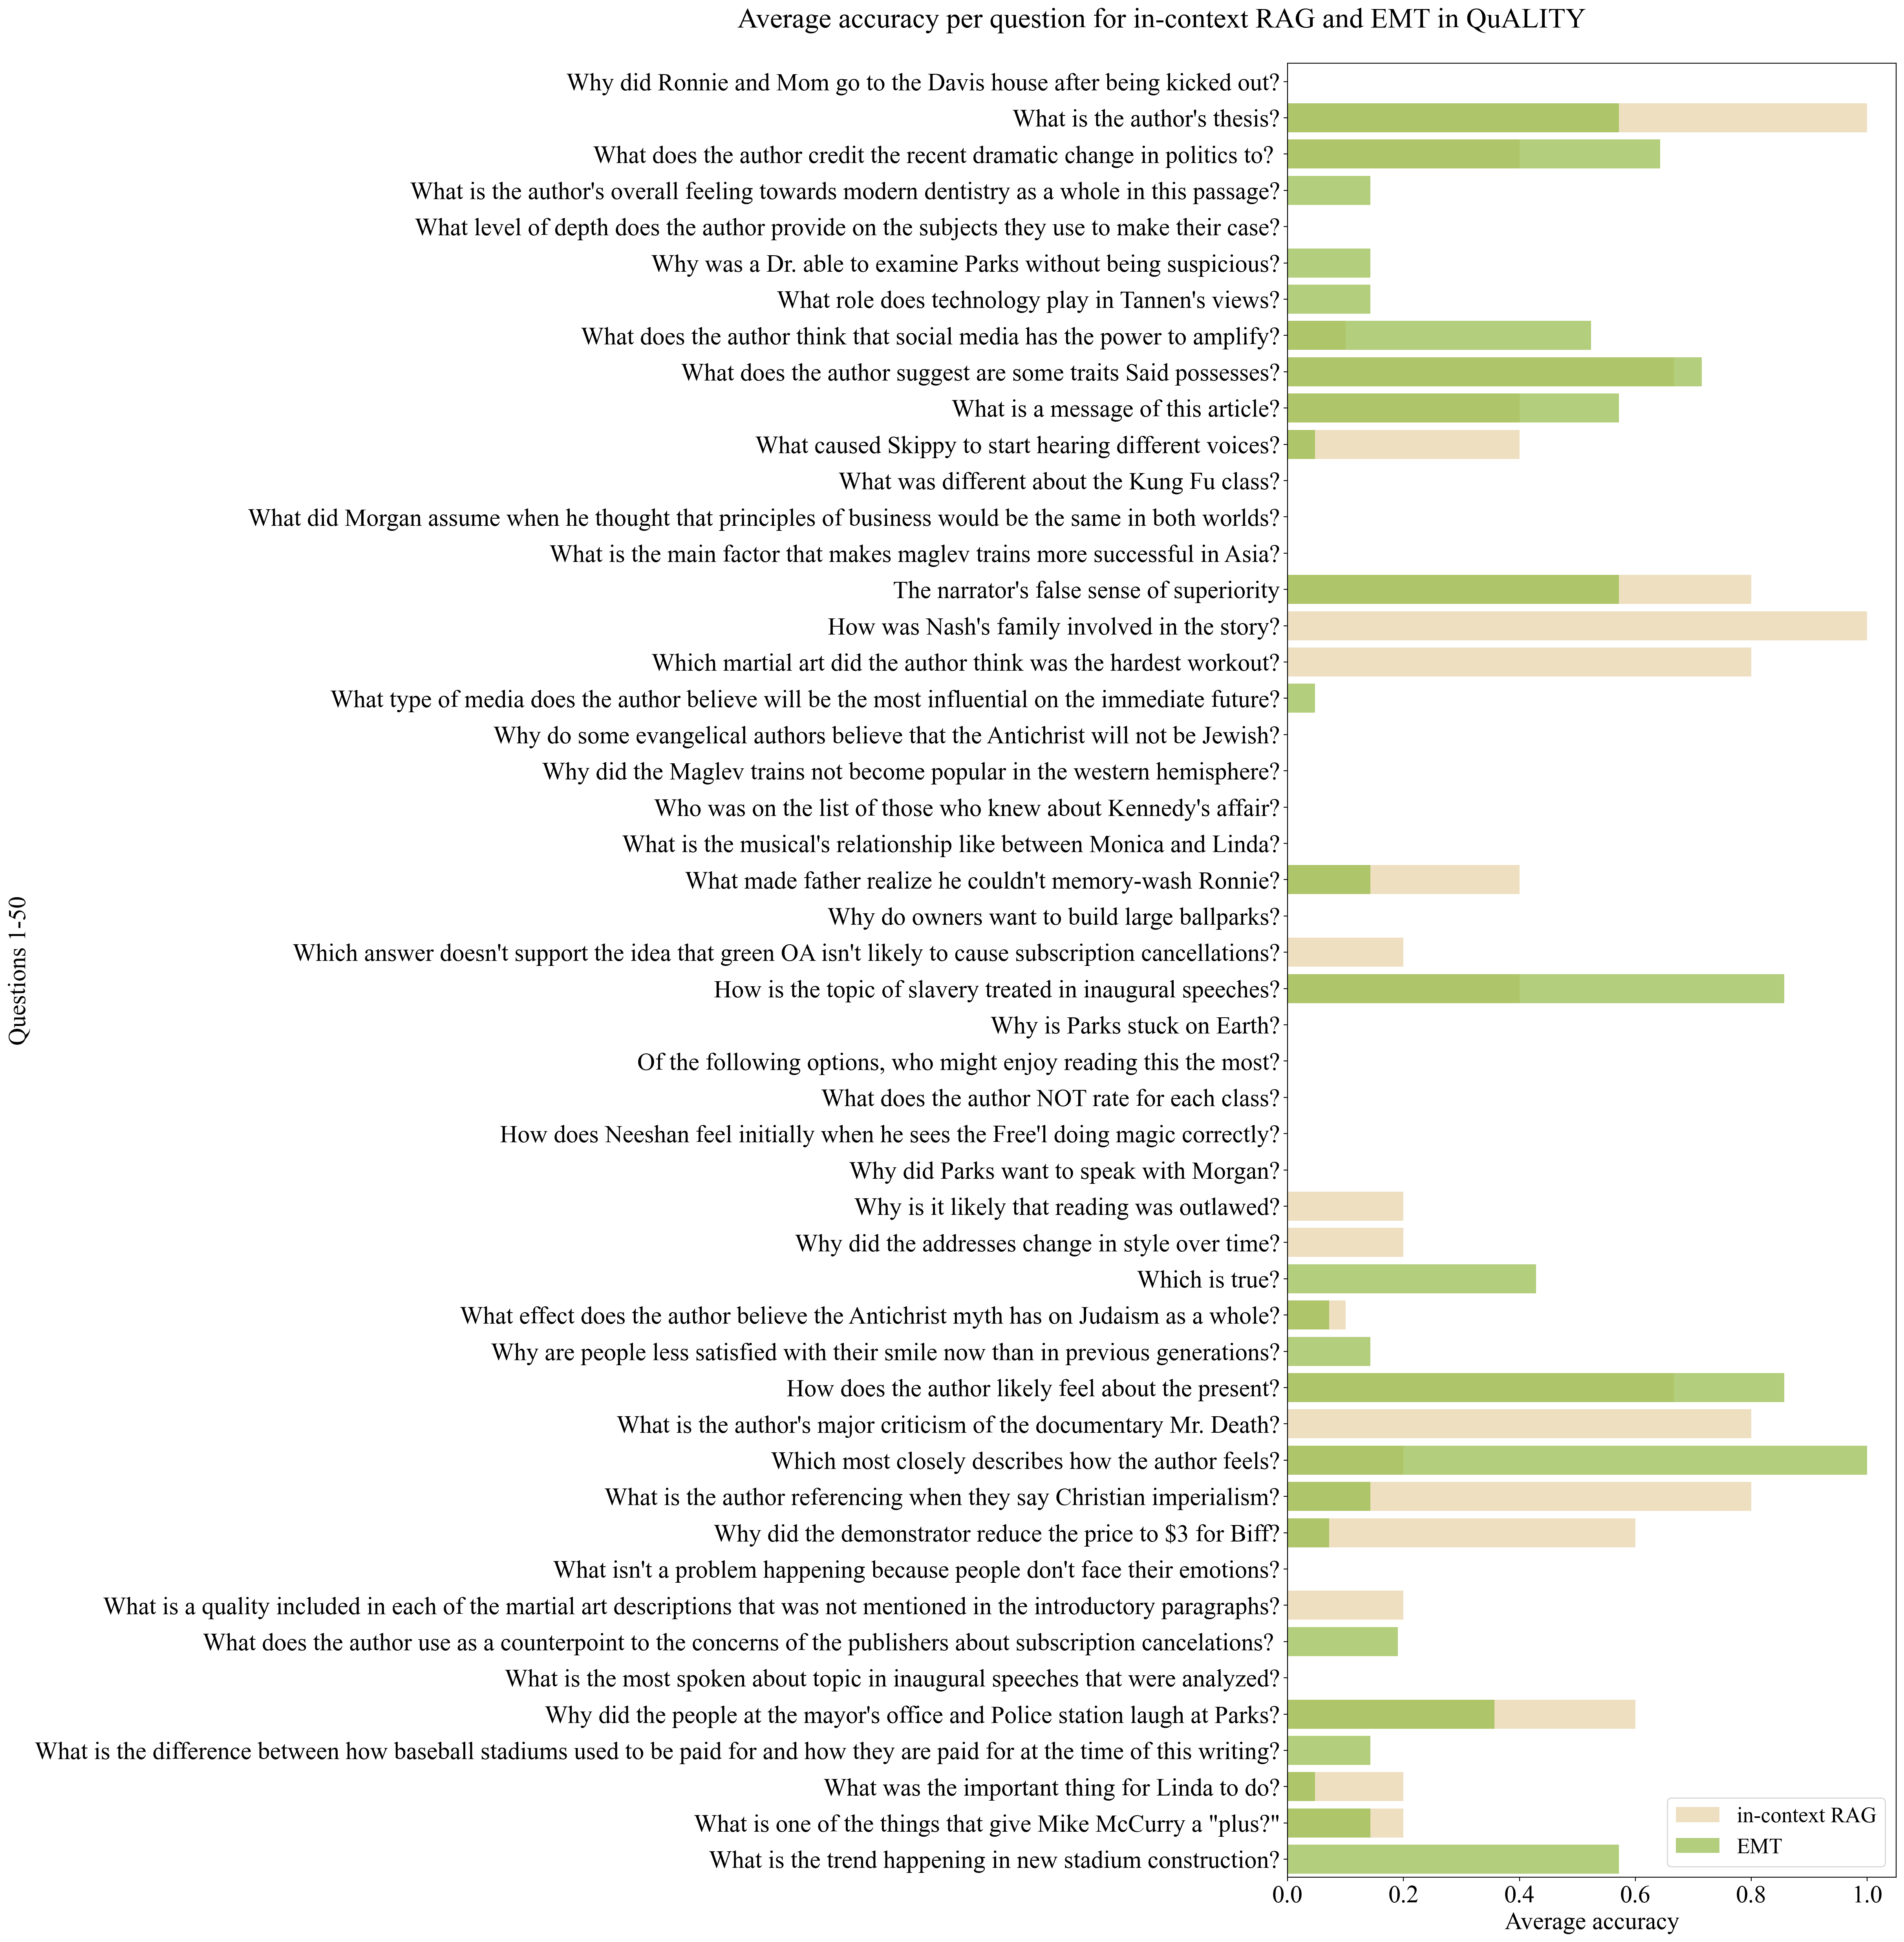

/Users/xmrt/Desktop/Master thesis/github/hmm/.venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128 (\x80) missing from font(s) Times New Roman.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/xmrt/Desktop/Master thesis/github/hmm/.venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 156 (\x9c) missing from font(s) Times New Roman.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/xmrt/Desktop/Master thesis/github/hmm/.venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 157 (\x9d) missing from font(s) Times New Roman.
  fig.canvas.print_figure(bytes_io, **kw)


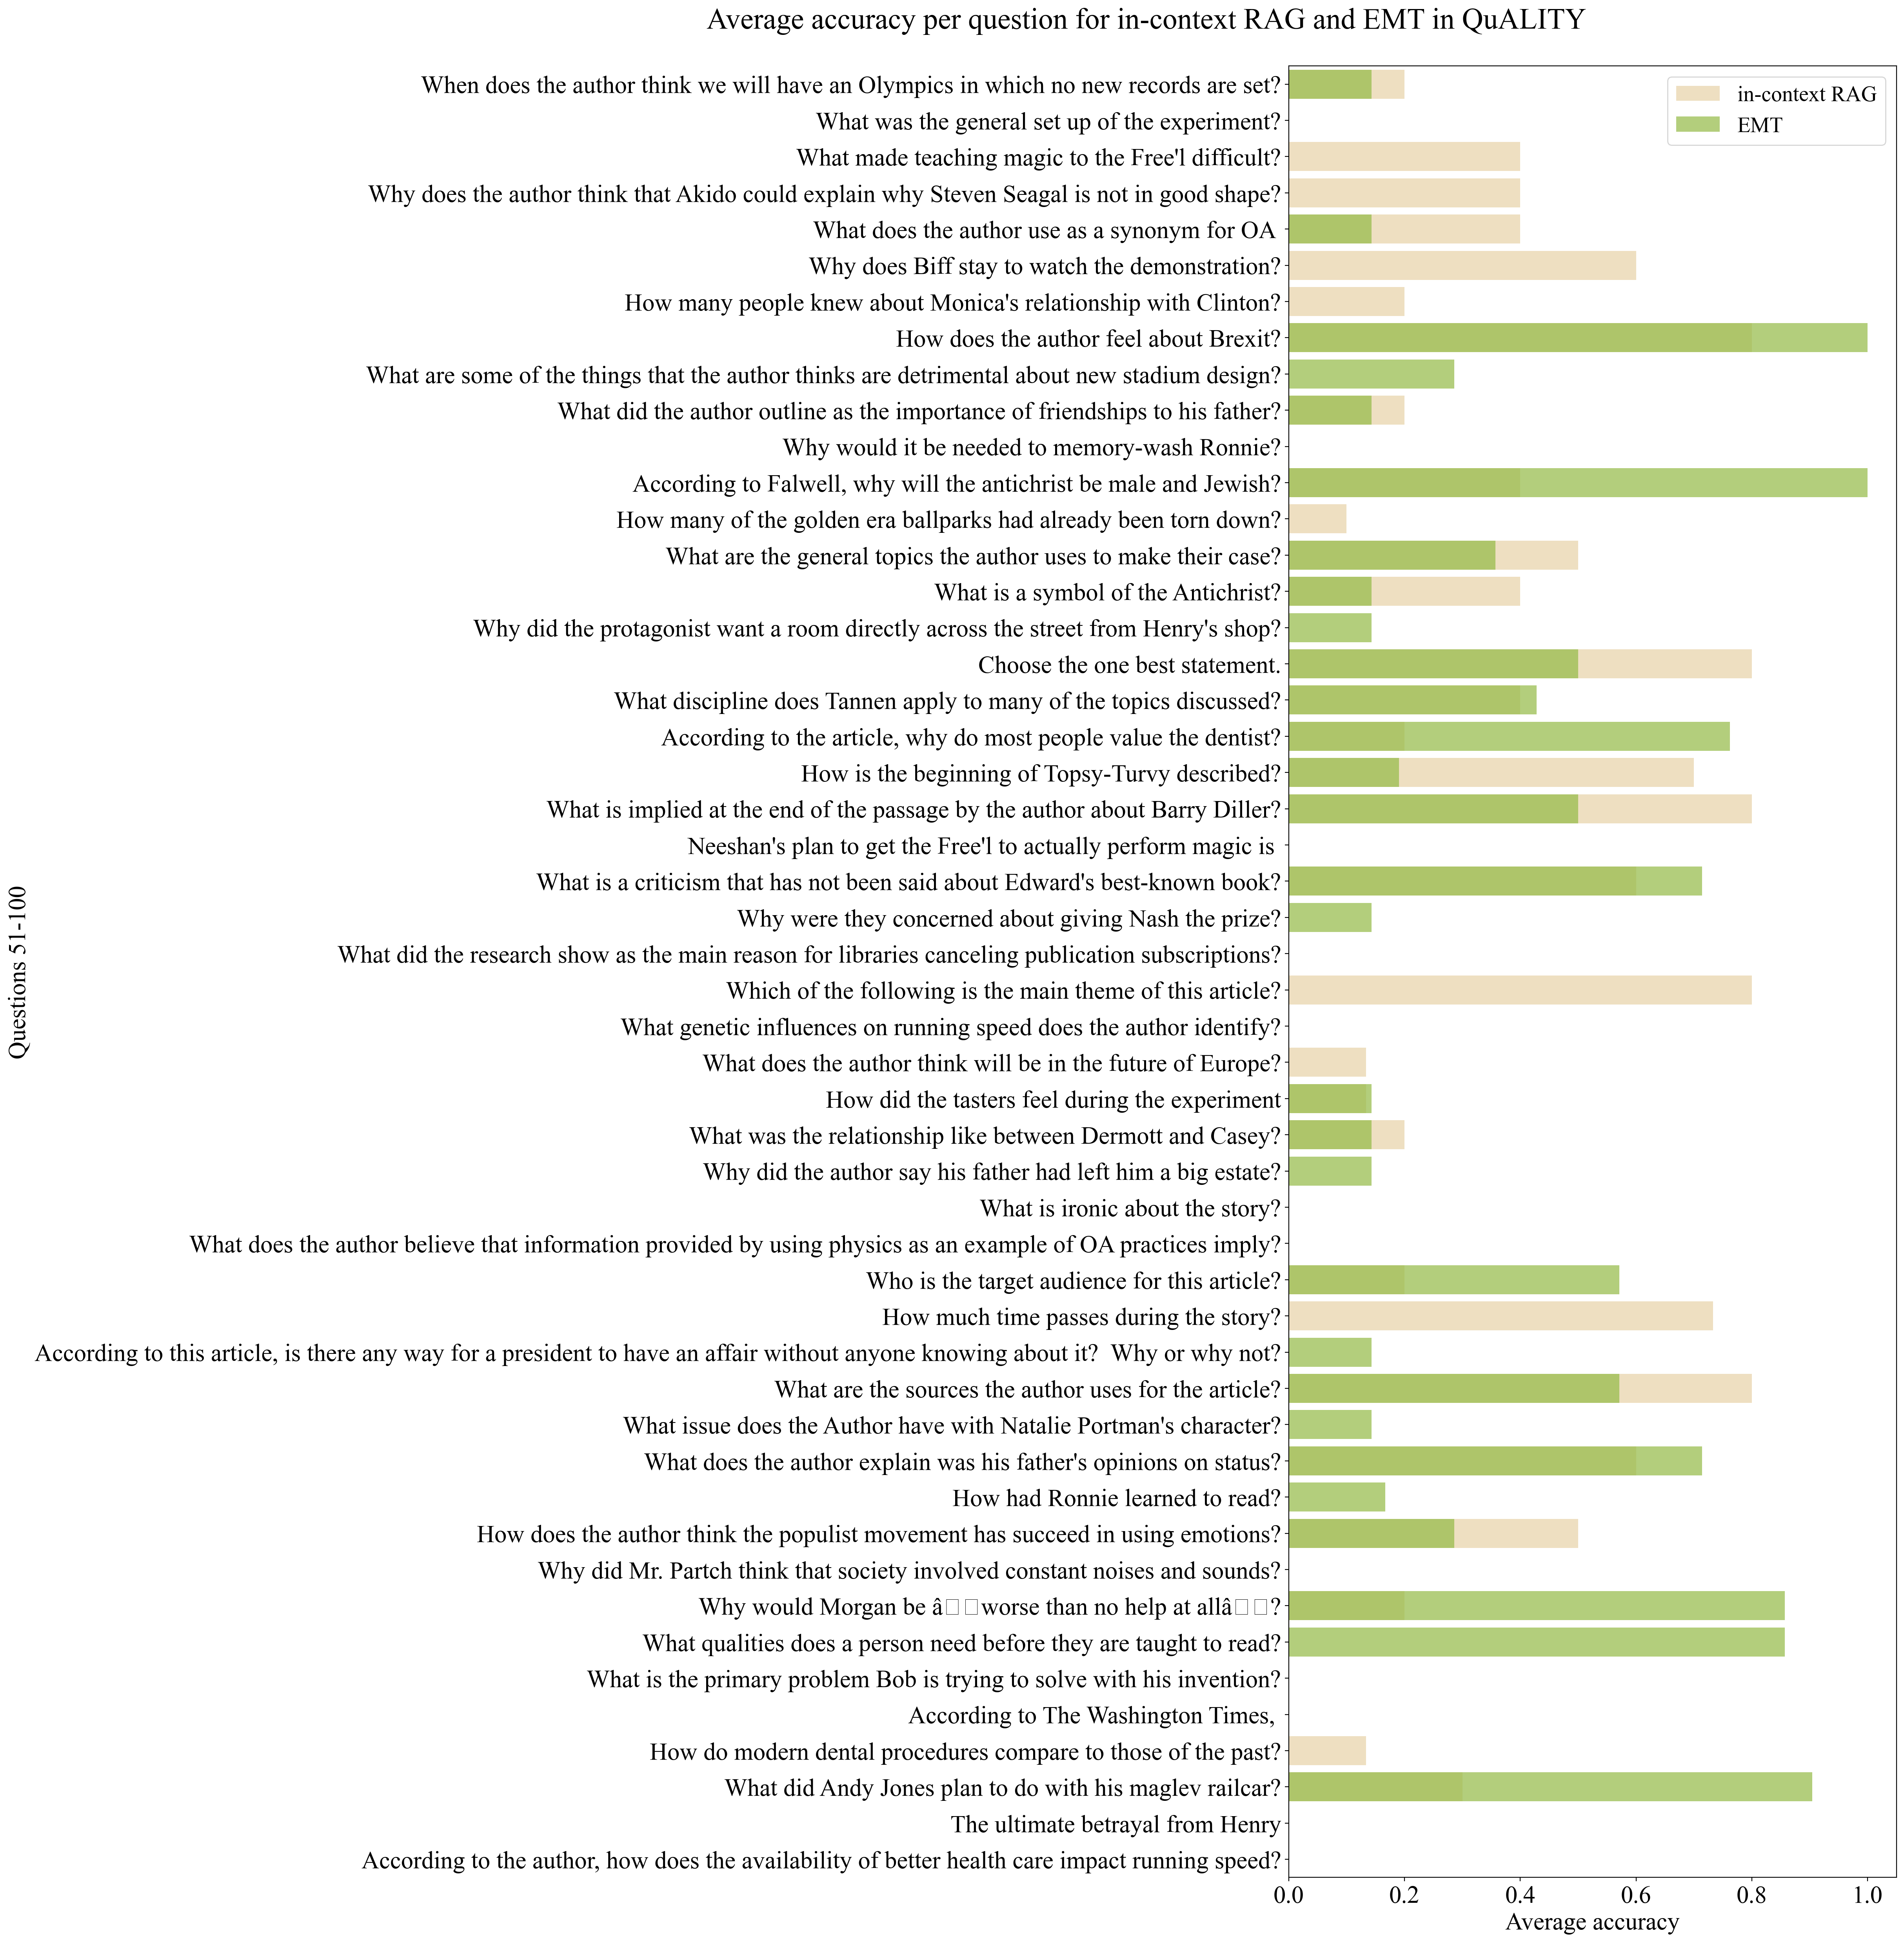

In [18]:

plt.rcParams['figure.dpi'] = 200
plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times New Roman"],
    "text.usetex": False
})

# Assuming df_rag and df_emt are pandas DataFrame objects
questions = df_rag['userprompt'].unique()
questions_emt = df_emt['userprompt'].unique()

acc_mean_rag = [df_rag[df_rag['userprompt'] == k]['in_predicted'].mean() for k in questions]
acc_mean_emt = [df_emt[df_emt['userprompt'] == k]['in_predicted'].mean() for k in questions_emt]

pattern = r": (.*?) 1\)"
questions = [re.search(pattern, q).group(1) if re.search(pattern, q) else q for q in questions]
questions=[i.replace("â\x80\x99", "'") for i in questions]

n = len(questions)
mid = n // 2
questions_1 = questions[:mid]
questions_2 = questions[mid:]

acc_mean_rag_1 = acc_mean_rag[:mid]
acc_mean_rag_2 = acc_mean_rag[mid:]

acc_mean_emt_1 = acc_mean_emt[:mid]
acc_mean_emt_2 = acc_mean_emt[mid:]

axes_size = 22.5
title_size = 26
legend_size = 20

# Create the first plot
plt.figure(figsize=(10, 30))
sns.barplot(x=acc_mean_rag_1, y=questions_1, orient='horizontal', color="#f5e1b9", label='in-context RAG')
sns.barplot(x=acc_mean_emt_1, y=questions_1, orient='horizontal', color="#9acd32", alpha=0.7, label='EMT')
plt.title('Average accuracy per question for in-context RAG and EMT in QuALITY \n', ha= 'right', fontsize=title_size)
plt.legend(fontsize=legend_size)
plt.ylabel('Questions 1-50', fontsize=axes_size)
plt.xlabel('Average accuracy', fontsize=axes_size)
plt.yticks(fontsize=axes_size)
plt.xticks(fontsize=axes_size)
plt.show()

# Create the second plot
plt.figure(figsize=(10, 30))
sns.barplot(x=acc_mean_rag_2, y=questions_2, orient='horizontal', color="#f5e1b9", label='in-context RAG')
sns.barplot(x=acc_mean_emt_2, y=questions_2, orient='horizontal', color="#9acd32", alpha=0.7, label='EMT')
plt.title('Average accuracy per question for in-context RAG and EMT in QuALITY \n', ha= 'right', fontsize=title_size+1)
plt.ylabel('Questions 51-100', fontsize=axes_size)
plt.xlabel('Average accuracy', fontsize=axes_size)
plt.legend(fontsize=legend_size)
plt.yticks(fontsize=axes_size)
plt.xticks(fontsize=axes_size)
plt.show()